# PYTORCH WGAN

In [1]:
# For COLAB
# from google.colab import drive
# drive.mount('/content/gdrive')

# !pip install kaggle Pillow imageio matplotlib pandas torchsummary
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download xhlulu/140k-real-and-fake-faces
# # ! unzip -q 140k-real-and-fake-faces.zip

# import shutil
# shutil.unpack_archive('140k-real-and-fake-faces.zip')

In [2]:
import os
import numpy as np
import datetime
from copy import deepcopy
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision.utils import save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary

In [3]:
# Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 20
BATCH_SIZE = 256
TRAIN_SUBSET_SIZE = 25000
LEARNING_RATE = 1e-4
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10

## Model

In [4]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            self._block(features_d * 8, features_d * 16, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 16, 1, kernel_size=2, stride=1, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

d = Discriminator(3, 64)
d.cuda()
summary(d, ( 3, 64, 64))
del d
torch.cuda.empty_cache()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
    InstanceNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
    InstanceNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
   InstanceNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12           [-1, 1024, 2, 2]       8,388,608
   InstanceNorm2d-13           [-1, 1024, 2, 2]           2,048
        LeakyReLU-14           [-1, 102

In [5]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 2, 1, 0),  # img: 2x2
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 4x4
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 8x8
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 16x16
            self._block(features_g * 2, features_g, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

g = Generator(100, 3, 64)
g.cuda()
summary(g, ( 100, 1, 1))
del g
torch.cuda.empty_cache()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 2, 2]         409,600
       BatchNorm2d-2           [-1, 1024, 2, 2]           2,048
              ReLU-3           [-1, 1024, 2, 2]               0
   ConvTranspose2d-4            [-1, 512, 4, 4]       8,388,608
       BatchNorm2d-5            [-1, 512, 4, 4]           1,024
              ReLU-6            [-1, 512, 4, 4]               0
   ConvTranspose2d-7            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-8            [-1, 256, 8, 8]             512
              ReLU-9            [-1, 256, 8, 8]               0
  ConvTranspose2d-10          [-1, 128, 16, 16]         524,288
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
  ConvTranspose2d-13           [-1, 64, 32, 32]         131,072
      BatchNorm2d-14           [-1, 64,

## Training

### Utils

In [ ]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(state, filename="wgan.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, gen, disc):
    print("=> Loading checkpoint")
    gen.load_state_dict(checkpoint['gen'])
    disc.load_state_dict(checkpoint['disc'])

### Training loop

In [ ]:
def create_dataloader(data_path, subset_size, batch_size, img_size, channels_img, class_label='real'):
    data_transforms = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * channels_img, [0.5] * channels_img),
    ])

    dataset = datasets.ImageFolder(root=data_path, transform=data_transforms)
    class_idx = dataset.class_to_idx[class_label]
    class_indices = [i for i, label in enumerate(dataset.targets) if label == class_idx]
    subset_indices = random.sample(class_indices, subset_size)
    subset_dataset = Subset(dataset, subset_indices)
    dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
    return dataloader

train_loader = create_dataloader("real_vs_fake/real-vs-fake/train", TRAIN_SUBSET_SIZE, BATCH_SIZE, IMAGE_SIZE, CHANNELS_IMG)

# initialize gen and disc/critic
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# For showing progress
fixed_noise = torch.randn(1, Z_DIM, 1, 1).to(device)

gen_losses = []
critic_losses = []

gen.train()
critic.train()

log_folder_name = f"logs/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}/"
os.makedirs(log_folder_name, exist_ok=True)
for epoch in range(11,31, 1):
    print(f"Epoch [{epoch}/{NUM_EPOCHS}]", end=" ")
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(tqdm(train_loader, desc="Batches")):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp)
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    gen_losses.append(loss_gen.item())
    critic_losses.append(loss_critic.item())

    print(f"Loss D: {loss_critic:.4f}, Loss G: {loss_gen:.4f}")

    gen.eval()
    critic.eval()

    with torch.no_grad():
        fake = gen(fixed_noise)
        os.makedirs(log_folder_name + "training", exist_ok=True)
        save_image(fake, log_folder_name + f"training/fake_epoch_{epoch}.png", normalize=True)

    gen.train()
    critic.train()

Epoch [11/20] 

Batches: 100%|██████████| 98/98 [01:46<00:00,  1.08s/it]


Loss D: -16.5341, Loss G: 97.9687
Epoch [12/20] 

Batches: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it]


Loss D: -13.2930, Loss G: 93.4868
Epoch [13/20] 

Batches: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it]


Loss D: -13.6475, Loss G: 82.9443
Epoch [14/20] 

Batches: 100%|██████████| 98/98 [01:45<00:00,  1.08s/it]


Loss D: -14.0204, Loss G: 87.5858
Epoch [15/20] 

Batches: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it]


Loss D: -11.2203, Loss G: 76.3394
Epoch [16/20] 

Batches: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it]


Loss D: -10.0651, Loss G: 80.9832
Epoch [17/20] 

Batches: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it]


Loss D: -12.1999, Loss G: 89.4890
Epoch [18/20] 

Batches: 100%|██████████| 98/98 [01:44<00:00,  1.06s/it]


Loss D: -10.8098, Loss G: 81.5087
Epoch [19/20] 

Batches: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it]


Loss D: -10.2276, Loss G: 79.7577
Epoch [20/20] 

Batches: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it]


Loss D: -10.6046, Loss G: 77.6869
Epoch [21/20] 

Batches: 100%|██████████| 98/98 [01:46<00:00,  1.09s/it]


Loss D: -9.7136, Loss G: 74.1605
Epoch [22/20] 

Batches: 100%|██████████| 98/98 [01:46<00:00,  1.08s/it]


Loss D: -11.4247, Loss G: 72.7803
Epoch [23/20] 

Batches: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it]


Loss D: -9.2532, Loss G: 73.2043
Epoch [24/20] 

Batches: 100%|██████████| 98/98 [01:48<00:00,  1.10s/it]


Loss D: -11.6760, Loss G: 74.0952
Epoch [25/20] 

Batches: 100%|██████████| 98/98 [01:55<00:00,  1.18s/it]


Loss D: -8.9663, Loss G: 71.5057
Epoch [26/20] 

Batches: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it]


Loss D: -9.3424, Loss G: 72.3037
Epoch [27/20] 

Batches: 100%|██████████| 98/98 [01:46<00:00,  1.08s/it]


Loss D: -8.5528, Loss G: 67.5661
Epoch [28/20] 

Batches: 100%|██████████| 98/98 [01:49<00:00,  1.12s/it]


Loss D: -8.8903, Loss G: 65.8960
Epoch [29/20] 

Batches: 100%|██████████| 98/98 [01:52<00:00,  1.15s/it]


Loss D: -8.7362, Loss G: 69.8204
Epoch [30/20] 

Batches: 100%|██████████| 98/98 [01:44<00:00,  1.07s/it]

Loss D: -8.4417, Loss G: 65.8123


In [ ]:
# Function to convert images to GIF
import os
from PIL import Image
def convert_images_to_gif(input_folder, output_gif_path):
    images = []
    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path)
            images.append(img)

    # Save images as GIF
    images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration=100, loop=1)

input_folder = log_folder_name +"training/"
output_gif_path = log_folder_name + "training.gif"

convert_images_to_gif(input_folder, output_gif_path)

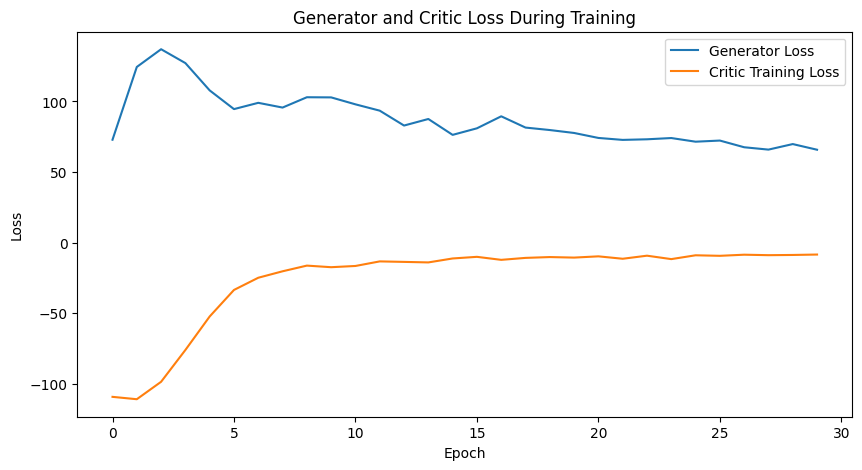

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label="Generator Loss")
plt.plot(critic_losses, label="Critic Training Loss")
plt.title("Generator and Critic Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(log_folder_name + "loss_curve_with_validation.png")  # Save the loss plot
plt.show()

In [ ]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
gen.load_state_dict(torch.load("models/generator.pth", weights_only=True))
gen.eval()

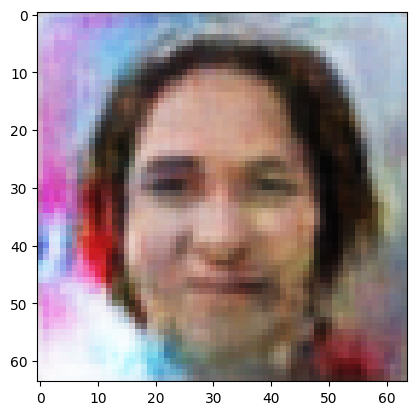

In [ ]:
imgs = gen(torch.randn(1, Z_DIM, 1, 1).to(device))
imgs = (imgs * 0.5) + 0.5
plt.imshow(imgs[0].cpu().detach().permute(1, 2, 0))

In [ ]:
import os
os.makedirs("models", exist_ok=True)
torch.save(gen.state_dict(), "models/generator.pth")
torch.save(critic.state_dict(), "models/critic.pth")

## Critic Re training

In [47]:
data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * CHANNELS_IMG, [0.5] * CHANNELS_IMG),
])

dataset = datasets.ImageFolder(root="real_vs_fake/real-vs-fake/train", transform=data_transforms)
class_idx = dataset.class_to_idx["real"]
indices = [i for i, label in enumerate(dataset.targets) if label==class_idx]
subset_indices = random.sample(indices, 25000)
subset_dataset = Subset(dataset, subset_indices)
train_loader = DataLoader(subset_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
print("No. of training images: ", len(subset_dataset))

dataset = datasets.ImageFolder(root="real_vs_fake/real-vs-fake/test", transform=data_transforms)
class_idx = dataset.class_to_idx["real"]
indices = [i for i, label in enumerate(dataset.targets) if label==class_idx]
subset_indices = random.sample(indices, 5000)
subset_dataset = Subset(dataset, subset_indices)
test_loader = DataLoader(subset_dataset, batch_size=5000, shuffle=False, drop_last=True)
print("No. of testing images: ", len(subset_dataset))

dataset = datasets.ImageFolder(root="real_vs_fake/real-vs-fake/valid", transform=data_transforms)
class_idx = dataset.class_to_idx["real"]
indices = [i for i, label in enumerate(dataset.targets) if label==class_idx]
subset_indices = random.sample(indices, 5000)
subset_dataset = Subset(dataset, subset_indices)
valid_loader = DataLoader(subset_dataset, batch_size=5000, shuffle=False, drop_last=True)
print("No. of validation images: ", len(subset_dataset))

No. of training images:  25000
No. of testing images:  5000
No. of validation images:  5000


In [48]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN)
gen.to(device)
gen.load_state_dict(torch.load("generator.pth", weights_only=True))
gen.eval()

Generator(
  (net): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(2, 2), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Sequential(
      (0): C

In [49]:
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC)
critic.disc.add_module("7",nn.Flatten())
critic.disc.add_module("8",nn.Sigmoid())
critic.to(device)
critic.load_state_dict(torch.load("critic.pth", weights_only=True))
summary(critic, ( 3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
    InstanceNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
    InstanceNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
   InstanceNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12           [-1, 1024, 2, 2]       8,388,608
   InstanceNorm2d-13           [-1, 1024, 2, 2]           2,048
        LeakyReLU-14           [-1, 102

In [50]:
optimizer = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
criterion = nn.BCELoss()
train_losses = []
valid_losses = []
fixed_valid_vector = torch.randn(5000, Z_DIM, 1, 1).to(device)
epoch = 0
least_loss = np.inf
EPOCHS_CRITIC = 5

In [51]:
for i in range(epoch, epoch + EPOCHS_CRITIC, 1):
    print(f"\nEPOCH [{i}/10] ", end=" ")
    critic.train()
    train_running_loss = 0.0
    # Training
    for real_images, real_labels in tqdm(train_loader, total=len(train_loader)):
        # On real images
        real_images, real_labels = real_images.to(device), real_labels.to(device).float()
        optimizer.zero_grad()
        outputs = critic(real_images).squeeze()  # Remove extra dimension from output
        real_loss = criterion(outputs, real_labels)

        # On generator images
        fake_images = gen(torch.randn(BATCH_SIZE, Z_DIM, 1, 1).to(device)).to(device)
        fake_labels = torch.zeros_like(real_labels).to(device).float()
        fake_outputs = critic(fake_images).squeeze()
        fake_loss = criterion(fake_outputs, fake_labels)

        loss = real_loss + fake_loss
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    epoch_train_loss = train_running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    print(f"Loss: {epoch_train_loss} ", end="\t")

    # Validation
    critic.eval()
    valid_running_loss = 0.0
    with torch.no_grad():
        for read_images, real_labels in valid_loader:

            read_images, real_labels = read_images.to(device), real_labels.to(device).float()
            real_outputs = critic(read_images).squeeze()  # Remove extra dimension from output
            real_loss = criterion(real_outputs, real_labels.squeeze())

            fake_images, fake_labels = gen(fixed_valid_vector).to(device), torch.zeros_like(real_labels).to(device).float()
            fake_outputs = critic(fake_images).squeeze()
            fake_loss = criterion(fake_outputs, fake_labels.squeeze())

            loss = real_loss + fake_loss
            valid_running_loss += loss.item()
        epoch_valid_loss = valid_running_loss / len(valid_loader)
    valid_losses.append(epoch_valid_loss)
    print(f"Validation Loss: {epoch_valid_loss}",end="\t")

    if epoch_valid_loss < least_loss:
        least_loss = epoch_valid_loss
        torch.save(deepcopy(critic.state_dict()), "critic_retrained.pth")
        print("INFO:Lowest validation Model saved")




EPOCH [0/10]  

100%|██████████| 97/97 [01:42<00:00,  1.06s/it]


Loss: 8.265512586868915 	Validation Loss: 2.4075894355773926	INFO:Lowest validation Model saved

EPOCH [1/10]  

100%|██████████| 97/97 [01:36<00:00,  1.01it/s]


Loss: 1.8431945615208025 	Validation Loss: 1.4747475385665894	INFO:Lowest validation Model saved

EPOCH [2/10]  

100%|██████████| 97/97 [01:36<00:00,  1.01it/s]


Loss: 1.1038756453499352 	Validation Loss: 1.9257885217666626	
EPOCH [3/10]  

100%|██████████| 97/97 [01:35<00:00,  1.01it/s]


Loss: 0.8509512368551234 	Validation Loss: 0.16020146012306213	INFO:Lowest validation Model saved

EPOCH [4/10]  

100%|██████████| 97/97 [01:36<00:00,  1.00it/s]


Loss: 0.7085613588389662 	Validation Loss: 0.11170648038387299	INFO:Lowest validation Model saved


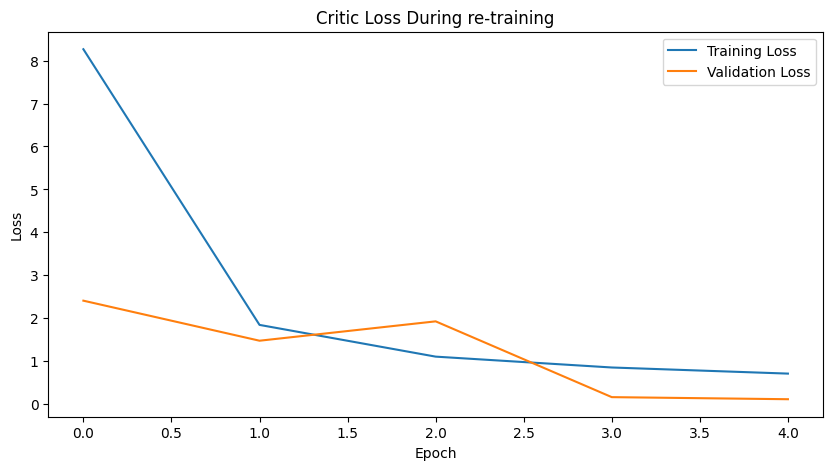

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.title("Critic Loss During re-training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [53]:
critic.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device).float()
    outputs = critic(images).squeeze()

    loss = criterion(outputs, labels)

    predictions = (outputs >= 0.5).float()
    correct += (predictions == labels).sum().item()
    total += labels.size(0)

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy}% Loss: {loss}')

Accuracy: 0.9774% Loss: 0.06956614553928375


## ~~Style gan benchmark~~

In [13]:
data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * CHANNELS_IMG, [0.5] * CHANNELS_IMG),
])

dataset = datasets.ImageFolder(root="real_vs_fake/real-vs-fake/test", transform=data_transforms)
real_class_idx = dataset.class_to_idx["real"]
fake_class_idx = dataset.class_to_idx["fake"]
real_indices = [i for i, label in enumerate(dataset.targets) if label==real_class_idx]
fake_indices = [i for i, label in enumerate(dataset.targets) if label==fake_class_idx]
real_subset_indices = random.sample(real_indices, 5000)
fake_subset_indices = random.sample(fake_indices, 5000)
subset_indices = real_subset_indices + fake_subset_indices
subset_dataset = Subset(dataset, subset_indices)
test_loader = DataLoader(subset_dataset, batch_size=10000, shuffle=False, drop_last=True)
print("No. of testing images: ", len(subset_dataset))

No. of testing images:  10000


In [16]:
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC)
critic.disc.add_module("7",nn.Flatten())
critic.disc.add_module("8",nn.Sigmoid())
critic.to(device)
critic.load_state_dict(torch.load("models/critic_retrained.pth", weights_only=True))
summary(critic, ( 3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
    InstanceNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
    InstanceNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
   InstanceNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12           [-1, 1024, 2, 2]       8,388,608
   InstanceNorm2d-13           [-1, 1024, 2, 2]           2,048
        LeakyReLU-14           [-1, 102

In [18]:
criterion = nn.BCELoss()
critic.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device).float()
    outputs = critic(images).squeeze()

    loss = criterion(outputs, labels)

    predictions = (outputs >= 0.5).float()
    correct += (predictions == labels).sum().item()
    total += labels.size(0)

# Calculate accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy}% Loss: {loss}')

Accuracy: 0.4951% Loss: 3.2170722484588623
